In [1]:
from smt.surrogate_models import KRG
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [2]:
def UF7(x):
    J1 = 0
    J2 = 0

    sum1 = 0
    sum2 = 0
    for j in range(1, len(x)):
        if j % 2 == 0:
            J1 += 1
            sum1 += (x[j] - np.sin(6 * np.pi * x[0] + ((j+1) * np.pi) / len(x))) ** 2
        if j % 2 == 1:
            J2 += 1
            sum2 += (x[j] - np.sin(6 * np.pi * x[0] + ((j+1) * np.pi) / len(x))) ** 2

    if J1 == 0:
        f1 = x[0]
    else:
        f1 = x[0] + 2 / J1 * sum1

    if J2 == 0:
        f2 = 1 - np.sqrt(x[0])
    else:
        f2 = 1 - np.sqrt(x[0]) + 2 / J2 * sum2
    return [f1, f2]

def MOEADDE_F5(x):
    J1 = 0
    J2 = 0

    sum1 = 0
    sum2 = 0
    for j in range(1, len(x)):
        if j % 2 == 0:
            J1 += 1
            sum1 += (x[j] - (0.3 * x[0] ** 2 * np.cos(24 * np.pi * x[0] + (4 * (j+1) * np.pi) / len(x))+0.6*x[0]) * np.cos(6 * np.pi * x[0] + ((j+1) * np.pi)/len(x))) ** 2
        if j % 2 == 1:
            J2 += 1
            sum2 += (x[j] - (0.3 * x[0] ** 2 * np.cos(24 * np.pi * x[0] + (4 * (j+1) * np.pi) / len(x))+0.6*x[0]) * np.sin(6 * np.pi * x[0] + ((j+1) * np.pi)/len(x))) ** 2

    if J1 == 0:
        f1 = x[0]
    else:
        f1 = x[0] + 2 / J1 * sum1

    if J2 == 0:
        f2 = 1 - np.sqrt(x[0])
    else:
        f2 = 1 - np.sqrt(x[0]) + 2 / J2 * sum2
    return [f1, f2]

def MOEADDE_F8(x):
    J1 = 0
    J2 = 0

    sum1 = 0
    sum2 = 0
    mul1 = 1
    mul2 = 1
    for j in range(1, len(x)):
        if j % 2 == 0:
            J1 += 1
            y = x[j] - x[0] ** (0.5 * (1.0 + (3 * (j + 1 - 2)) / (len(x) - 2)))
            sum1 += y ** 2
            mul1 *= np.cos((20 * y * np.pi) / np.sqrt(j + 1))
        if j % 2 == 1:
            J2 += 1
            y = x[j] - x[0] ** (0.5 * (1.0 + (3 * (j + 1 - 2)) / (len(x) - 2)))
            sum2 += y ** 2
            mul2 *= np.cos((20 * y * np.pi) / np.sqrt(j + 1))

    if J1 == 0:
        f1 = x[0]
    else:
        f1 = x[0] + 2 / J1 * (4 * sum1 - 2 * mul1 + 2)

    if J2 == 0:
        f2 = 1 - np.sqrt(x[0])
    else:
        f2 = 1 - np.sqrt(x[0]) + 2 / J2 * (4 * sum2 - 2 * mul2 + 2)
    return [f1, f2]

def UF4(x):
    J1 = 0
    J2 = 0
    sum1 = 0
    sum2 = 0

    for j in range(1, len(x)):
        if j % 2 == 0:
            J1 += 1
            y = x[j] - np.sin(6 * np.pi * x[0] + ((j + 1) * np.pi) / len(x))
            h = np.abs(y) / (1 + np.exp(2 * np.abs(y)))
            sum1 += h
        if j % 2 == 1:
            J2 += 1
            y = x[j] - np.sin(6 * np.pi * x[0] + ((j + 1) * np.pi) / len(x))
            h = np.abs(y) / (1 + np.exp(2 * np.abs(y)))
            sum2 += h

    if J1 == 0:
        f1 = x[0]
    else:
        f1 = x[0] + 2 / J1 * sum1

    if J2 == 0:
        f2 = 1 - x[0] ** 2
    else:
        f2 = 1 - x[0] ** 2 + 2 / J1 * sum2
    return [f1, f2]

def MOEADDE_F9(x):
    J1 = 0
    J2 = 0
    sum1 = 0
    sum2 = 0

    for j in range(1, len(x)):
        if j % 2 == 0:
            J1 += 1
            y = x[j] - np.sin(6 * np.pi * x[0] + ((j + 1) * np.pi) / len(x))
            sum1 += y ** 2
        if j % 2 == 1:
            J2 += 1
            y = x[j] - np.sin(6 * np.pi * x[0] + ((j + 1) * np.pi) / len(x))
            sum2 += y ** 2

    if J1 == 0:
        f1 = x[0] ** 0.2
    else:
        f1 = x[0] ** 0.2 + 2 / J1 * sum1

    if J2 == 0:
        f2 = 1 - x[0] ** 0.2
    else:
        f2 = 1 - x[0] ** 0.2 + 2 / J2 * sum2
    return [f1, f2]

In [12]:
def create_pop(size_pop, n, min_val, max_val):
    population = np.zeros((size_pop, n))
    for i in range(size_pop):
        population[i][0] = np.random.uniform(0, 1)
        for j in range(1, n):
            population[i][j] = np.random.uniform(min_val, max_val)
    return population

def get_betaq(rand, alpha, eta):
    if rand <= 1.0/alpha:
        return (rand * alpha) ** (1.0/eta + 1.0)
    else:
        return (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))


def SBX(eta, parent1, parent2, Left, Right):
    child = np.array([])

    for i in range(n):
        if parent1[i] > parent2[i]:
            parent1[i], parent2[i] = parent2[i], parent1[i]
        if (parent2[i] - parent1[i]) < 10e-8:
            if np.random.random() <= 0.5:
                child = np.append(child, parent1[i])
                continue
            else:
                child = np.append(child, parent2[i])
                continue

        flag = True
        while flag:
            rand = np.random.random()
            if np.random.random() <= 0.5:
                beta = 1.0 + (2.0 * (parent1[i] - Left[i])/(parent2[i] - parent1[i]))
                alpha = 2.0 - beta ** (-(eta + 1.0))
                betaq = get_betaq(rand, alpha, eta)
                x1_new = 0.5 * ((parent1[i] + parent2[i]) - betaq * (parent2[i] - parent1[i]))
                if x1_new >= Left[i] and x1_new <= Right[i]:
                    child = np.append(child, x1_new)
                    flag = False
            else:
                beta = 1.0 + (2.0 * (Right[i] - parent2[i]))/(parent2[i] - parent1[i])
                alpha = 2.0 - beta ** (-(eta + 1.0))
                betaq = get_betaq(rand, alpha, eta)
                x2_new = 0.5 * ((parent1[i] + parent2[i]) + betaq * (parent2[i] - parent1[i]))
                if x2_new >= Left[i] and x2_new <= Right[i]:
                    child = np.append(child, x2_new)
                    flag = False
    return child


def PolyMut(eta, ind, Left, Right):

    mutated_ind = np.array([])

    for i in range(len(ind)):
        y = np.copy(ind[i])
        delta1 = (y - Left[i])/(Right[i] - Left[i])
        delta2 = (Right[i] - y)/(Right[i] - Left[i])
        mut_pow = 1.0/(eta + 1.0)
        rand = np.random.random()
        if rand <= 0.5:
            xy = 1.0 - delta1
            val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1.0))
            deltaq = (val ** mut_pow) - 1.0
        else:
            xy = 1.0 - delta2
            val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1.0))
            deltaq = 1.0 - val ** mut_pow

        y = y + deltaq * (Right[i] - Left[i])
        y = min(Right[i], max(Left[i], y))
        mutated_ind = np.append(mutated_ind, y)

    return mutated_ind


def distance(w):
    dist = np.array([])

    for i in range(size_pop):
        for j in range(size_pop):
            dist = np.append(dist, np.sqrt(np.sum((w[i]-w[j]) ** 2)))

    dist = dist.reshape(size_pop, size_pop)

    return dist

def neighbors(dist, T):
    nei = np.array([])
    for i in range(len(dist)):
        arr = np.argsort(dist[i])
        arr = arr[1:T+1]
        nei = np.append(nei, arr)

    nei = nei.reshape(size_pop, T)

    return nei

def z(fitness):
    ref = np.array([])
    for i in range(fitness.shape[1]):
        ref = np.append(ref, np.min(np.transpose(fitness)[i]))

    return ref

def nChoosek (n, k):
    if k > n:
        return 0
    if k * 2 > n:
        k = n - k
    if k == 0:
        return 1

    result = n
    for i in range(2, k + 1):
        result *= n - i + 1
        result //= i

    return result

def getSLRP(num_ind, num_obj):
    H1 = 1
    while nChoosek(H1 + num_obj, num_obj - 1) <= num_ind:
        H1 += 1
    npoints = nChoosek(H1 + num_obj - 1, num_obj - 1)
    points = np.zeros((npoints, num_obj))
    points2 = np.zeros((npoints, num_obj))

    N = H1 + num_obj - 1
    M = num_obj - 1

    istart = np.zeros(N)
    iend = np.zeros(N)
    imass = np.zeros(N)

    for i in range(M):
        istart[i] = i + 1
        iend[i] = N - M + i + 2
        imass[i] = i + 1

    counter = 0
    while True:
        imass[M - 1] = istart[M - 1]
        while imass[M - 1] != iend[M - 1]:
            for j in range(M):
                points[counter][j] = imass[j]

            imass[M-1] += 1
            counter += 1

        NFinished = 0
        for i in range(M-1, -1, -1):
            if imass[i] == iend[i]:
                NFinished += 1
            if imass[i] == iend[i]:
                if i > 0:
                    imass[i-1] += 1
                    for j in range(i, M):
                        istart[j] = imass[i-1] + j - i + 1
                        imass[j] = istart[j]

        if NFinished == M:
            break

    for i in range(npoints):
        for j in range(M):
            points[i][j] = points[i][j] - j - 1
            points2[i][j+1] = points[i][j]
        points2[i][0] = 0

    for i in range(npoints):
        points[i][M] = points[npoints - 1][0]
        for j in range(M + 1):
            points[i][j] = (points[i][j] - points2[i][j]) / H1
            if points[i][j] < 1E-6:
                points[i][j] = 1E-6

    return points


In [13]:
def MOEAD(size_pop, n, test, num_obj, T, num_calc, mode, num_calc_surr):
    calc = size_pop
    iter = 0
    w = getSLRP(size_pop, num_obj)
    dist = distance(w)
    B = neighbors(dist, T)
    population_true = create_pop(size_pop, n, min_val, max_val)
    fitness = np.apply_along_axis(test, 1, population_true)
    ref_z = z(fitness)
    if mode == 1:
        xt = np.copy(population_true)
        yt = fitness.reshape((size_pop, num_obj))
        models = np.array([])
        for j in range(num_obj):
            sm = KRG(theta0=[1e-2], print_global = False)
            sm.set_training_values(xt, yt[:, j])
            sm.train()
            models = np.append(models, sm)
    count_calculate = size_pop #кол-во вычислений функции на старте
    
    while calc < num_calc:
        surr = 0
        iter += 1
        population_surr = create_pop(size_pop, n, min_val, max_val)
        fitness_surr = np.zeros((size_pop, num_obj))
        ref_z = z(fitness_surr)
        while surr < num_calc_surr:                        
            for i, ind in enumerate (population_surr):
                for m in range(num_obj):
                    fit_model = models[m].predict_values
                    fitness_surr[i][m] = fit_model(ind.reshape(1, n))
                    surr += 1

            for i in range(size_pop):
                target = population_surr[i]
                k = np.random.randint(0, T)
                l = np.random.randint(0, T)
                xk = population_surr[int(B[i][k])]
                xl = population_surr[int(B[i][l])]
                child = SBX(eta, xk, xl, L, R)
                new_ind = PolyMut(eta, child, L, R)
                corrected_vector = new_ind
                for j in range(len(new_ind)):
                    if new_ind[j] < L[j]:
                        corrected_vector[j] = (target[j] + L[j]) / 2
                    elif new_ind[j] > R[j]:
                        corrected_vector[j] = (target[j] + R[j]) / 2
                    else:
                        corrected_vector[j] = new_ind[j]

                new_ind = corrected_vector

                if mode == 1:
                    fit_new = np.array([])    
                    for m in range(len(models)):
                        fit_model = models[m].predict_values
                        fit_new = np.append(fit_new, fit_model(new_ind.reshape(1, n)))
                        surr += 1

                else:
                    fit_new = test(new_ind)
                    calc += 1

                for j in range(len(ref_z)):
                    if ref_z[j] > fit_new[j]:
                        ref_z[j] = fit_new[j]

                for j in range(T):
                    gte_new_ind = np.max(w[i] * np.abs(fit_new - ref_z))
                    gte_ind = np.max(w[i] * np.abs(fitness_surr[int(B[i][j])] - ref_z))
                    if gte_new_ind < gte_ind:
                        population_surr[int(B[i][j])] = new_ind
                        #print(fitness_surr[int(B[i][j])].shape)
                        fitness_surr[int(B[i][j])] = fit_new
                        
        
                    
        if mode == 1:
            for ind in population_surr:
                if ind not in xt and calc < num_calc:
                    xt = np.vstack((xt, ind))
                    fitness = test(ind)
                    calc += 1
                    yt = np.vstack((yt, fitness))
            #print(f"Обучение на данных: {xt.shape}, {xt}")
            models = np.array([])
            for j in range(num_obj):
                sm = KRG(theta0=[1e-2], print_global = False)
                sm.set_training_values(xt, yt[:, j])
                sm.train()
                models = np.append(models, sm)
            #plt.scatter(yt[:,0],yt[:,1])
            #plt.show()
        

    return yt, xt

In [14]:
size_pop= 20
n = 3
num_obj = 2
min_val = -1
max_val = 1
T = 3
eta = 20
L = [0, -1, -1, -1]
R = [1, 1, 1, 1]
num_exp = 30
num_calc = 400 #кол-во вычислений
modes = 2
num_surr = 1000

In [15]:
tests = [test1, test2, test3, test4, test5]

In [16]:
def is_dominated(point, data):
    return np.any(np.all(data <= point, axis=1) & np.any(data < point, axis=1))

In [17]:
for mo in range(1, modes):
    for test in tests:

        list_IGD = np.array([])
        for exp in range(num_exp):
            _, population = MOEAD(size_pop, n, test, num_obj, T, num_calc, mo, num_surr)
            result = np.apply_along_axis(test, 1, population)

            pareto_front = np.array([point for point in result if not is_dominated(point, result)])
            np.savetxt(f'pareto_front_{test.__name__}_mode_KRG.txt', pareto_front)

              
            x = pareto_front[:, 0]
            y = pareto_front[:, 1]
            
            #print(front)
            if test.__name__ == test4:
                front_x = np.linspace(0, 1, 1000)
                front_y = 1 - front_x ** 2
                front = np.column_stack((front_x, front_y))
            elif test.__name__ == test5:
                front_x = np.linspace(0, 1, 1000)
                front_y = 1 - front_x
                front = np.column_stack((front_x, front_y))
            else:
                front_x = np.linspace(0, 1, 1000)
                front_y = 1 - np.sqrt(front_x)
                front = np.column_stack((front_x, front_y))
    
            distances = cdist(front, result)
            #print(distances.shape)
            min_dist = np.min(distances, axis=1)
            IGD = np.mean(min_dist)
            list_IGD = np.append(list_IGD, IGD)
            print(IGD)
            #print(list_IGD)
            print(f'Exp num: {exp + 1}')
        np.savetxt(f'result_{test.__name__}_mode_{mo}.txt', list_IGD)
        
    print(f'Mode {mo} finished!')


0.017704402714061183
Exp num: 1
0.01983703178796743
Exp num: 2
0.018268910548389264
Exp num: 3
0.01922752514172143
Exp num: 4
0.018634513302425153
Exp num: 5
0.021740691812771933
Exp num: 6
0.020153002078290697
Exp num: 7
0.022029549159535627
Exp num: 8
0.018753727631780702
Exp num: 9
0.01881719613896466
Exp num: 10
0.017666189462124383
Exp num: 11
0.02060820687377417
Exp num: 12
0.016669577708548693
Exp num: 13
0.020190818874698896
Exp num: 14
0.016566376773186085
Exp num: 15
0.02031123381714813
Exp num: 16
0.017305002486507876
Exp num: 17
0.024418498316297495
Exp num: 18
0.024031621502229983
Exp num: 19
0.02163138073963402
Exp num: 20
0.027007511756404718
Exp num: 21
0.01863392250221582
Exp num: 22
0.017197961758652063
Exp num: 23
0.022838506297135564
Exp num: 24
0.020293785007068955
Exp num: 25
0.016605307724420704
Exp num: 26
0.02362666275466726
Exp num: 27
0.01827919357580936
Exp num: 28
0.02200576250294114
Exp num: 29
0.02100237344002686
Exp num: 30
0.01813415203561531
Exp num: 1

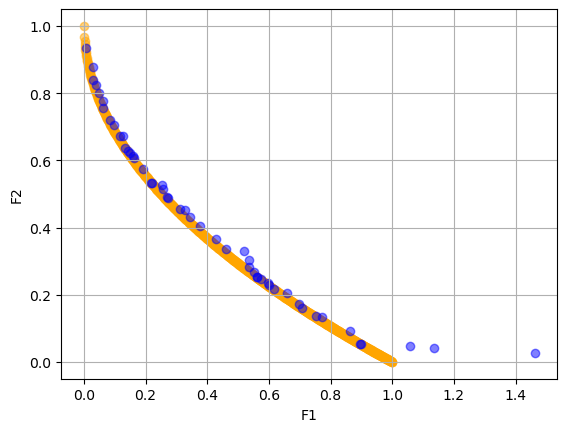

In [63]:
plt.scatter(front_x, front_y, color='orange', alpha=0.5)
plt.xlabel('F1')
plt.ylabel('F2')
plt.grid(True)

plt.scatter(x, y, color='blue', alpha=0.5)
plt.xlabel('F1')
plt.ylabel('F2')
plt.grid(True)
plt.show()

In [19]:
print(f"Кол-во индивидов: {size_pop}, Кол-во вычислений: {num_calc}, n = {n}")

dict_mean = {}
for test in tests:
    data1 = np.loadtxt(f'result_{test.__name__}_mode_0.txt')
    data2 = np.loadtxt(f'result_{test.__name__}_mode_1.txt')
    mean_value1 = np.mean(data1)
    mean_value2 = np.mean(data2)
    dict_mean[f'{test.__name__}'] = [mean_value1, mean_value2]

mean_df = pd.DataFrame(dict_mean, index=['MOEA', 'MOEA + KRG'])
print("IGD")
print(mean_df)

dict_median = {}
for test in tests:
    data1 = np.loadtxt(f'result_{test.__name__}_mode_0.txt')
    data2 = np.loadtxt(f'result_{test.__name__}_mode_1.txt')
    median_value1 = np.median(data1)
    median_value2 = np.median(data2)
    dict_median[f'{test.__name__}'] = [median_value1, median_value2]
    
median_df = pd.DataFrame(dict_median, index=['MOEA', 'MOEA + KRG'])
print('Медиана')
print(median_df)

dict_std = {}
for test in tests:
    data1 = np.loadtxt(f'result_{test.__name__}_mode_0.txt')
    data2 = np.loadtxt(f'result_{test.__name__}_mode_1.txt')
    std_value1 = np.std(data1)
    std_value2 = np.std(data2)
    dict_std[f'{test.__name__}'] = [std_value1, std_value2]

std_df = pd.DataFrame(dict_std, index=['MOEA', 'MOEA + KRG'])
print('Стандартное отклонение')
print(std_df)

Кол-во индивидов: 20, Кол-во вычислений: 400, n = 3
IGD
               test1     test2     test3     test4     test5
MOEA        0.199180  0.094264  0.640775  0.376736  0.336809
MOEA + KRG  0.020069  0.022345  0.332544  0.301700  0.145643
Медиана
               test1     test2     test3     test4     test5
MOEA        0.170886  0.095891  0.552912  0.377081  0.325152
MOEA + KRG  0.019995  0.019550  0.318182  0.301314  0.142298
Стандартное отклонение
               test1     test2     test3     test4     test5
MOEA        0.077687  0.016886  0.313178  0.029697  0.080867
MOEA + KRG  0.002549  0.009074  0.096106  0.010769  0.014599


In [23]:
from scipy.stats import mannwhitneyu

dict_mannwhitneyu = {}
for test in tests:
    group1 = np.loadtxt(f'result_{test.__name__}_mode_0.txt')
    group2 = np.loadtxt(f'result_{test.__name__}_mode_1.txt')
    stat, p = mannwhitneyu(group1, group2)
    dict_mannwhitneyu[f'{test.__name__}'] = [np.around(stat, decimals=3), p]

mannwhitneyu_df = pd.DataFrame(dict_mannwhitneyu, index=['U-статистика', 'p-значение'])
mannwhitneyu_df

,test1,test2,test3,test4,test5
U-статистика,9.000000e+02,9.000000e+02,8.140000e+02,8.980000e+02,9.000000e+02
p-значение,3.019859e-11,3.019859e-11,7.694964e-08,3.689726e-11,3.019859e-11


In [3]:
x = np.array([[0.9788,    0.4184,    0.5229],
    [0.7843,    0.9369,    0.7606],
    [0.4561,    0.2523,    0.1032],
    [0.4770,    0.0464,    0.4034],
    [0.9404,    0.1876,    0.1241]])

In [5]:
MOEADDE_F5(x.T)

[array([3.21156828, 1.43768021, 0.45935722, 0.52427954, 1.17609473]),
 array([0.35546699, 3.83977105, 0.89523888, 0.62149091, 0.05752135])]